# Homework 2

## FINM 37500 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

In [2]:
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../cmds')
from ficcvol import *
from binomial import *
from ratecurves import *

import matplotlib.pyplot as plt
import functools
import seaborn as sns

from scipy.optimize import fsolve
from scipy.stats import norm

In [3]:
def plot_time_series(df, title='Time Series Plot', x_label='Date', y_label='Price', rates = None):
    """
    plots a time series graph
    """
    if rates is None:
        df.index = pd.to_datetime(df.index)

    plt.figure(figsize=(14, 7)) 


    for column in df.columns:
        plt.plot(df.index, df[column], label=column)


  
    plt.xticks(rotation=45)  
    plt.xlabel(x_label) 
    plt.ylabel(y_label) 
    plt.title(title)  
    plt.legend()
    plt.tight_layout()
    plt.show()



def plot_correlation_matrix(df,title = 'Correlation Matrix Heatmap'):
    """
    This function takes a DataFrame with time series data in its columns,
    computes the correlation matrix, and then plots a heatmap using seaborn.
    """
    
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    corr_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title(title)
    plt.show()

# Set up

In [4]:
df = pd.read_excel('cap_curves_2024-02-16.xlsx').set_index('tenor')

# 1. Stripping Caps

The file `data/cap_curves_2024-02-16.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.
* the details of the data prep can be found in `build_data/Process Cap Quotes`.

## Context

Recall that 
* a cap is made of caplets with $.5\le \tau \le T$
* the flat volatility at $T$ is input for every caplet corresponding to the cap of $T$.
* use Black's formula for this calculation.
* in Black's formula, use $T-0.25$ as the rate for the caplet is determined one period before it is paid.

As for the cap parameters,
* the cap's strike is the swap rate with the same tenor. So the $T=2$ cap is struck at the swap rate of $\tau=2$.
* the notional of the cap is $100.
* the payoff of each caplet is

$$\frac{100}{n}\max(r-K,0)$$

where $n$ is the frequency; here $n=4$.

Thus, the corresponding value in Black's fomula for a caplet is
$$P^{\text{cap}}_{T} = \frac{100}{n} \sum_{\tau=.5}^T B_{\text{call}}(\overline{\sigma}_T, \tau-.25, K=s_T, f_{\tau}, Z_{\tau})$$
Note here that for every caplet in cap $T$, we plug in the same 
* flat vol with tenor $T$.
* strike which is the swap rate of maturity $T$.

The notation above is using subscripts for tenor / maturity rather than time period. That is, $Z_{\tau}$ denotes $Z(t, t+\tau)$ which is today's discount factor for maturity $\tau$. Similarly for the swap rate of tenor $T$, denoted above $s_T$ and forward rate $f(t,t+\tau-.25, t+\tau)$ denoted simply $f_{\tau}$.

### Black's Formula
Recall Black's formula:

$$\begin{align}
B_{\text{call}}(\sigma, T, K, f, Z) = &\; Z\left[f\mathcal{N}\left(d_1\right) - K\mathcal{N}(d_2)\right] \\
d_1 =& \frac{\ln\left(\frac{f}{K}\right) + \frac{\sigma^2}{2}T}{\sigma\sqrt{T}} \\
d_2 =& d_1 -\sigma\sqrt{T}
\end{align}
$$

In [5]:
def solve_forward_volatility(row, previous_vol):
    if np.isnan(row['flat vols']):
        return np.nan
    T = row.name
    flat_vol = row['flat vols']
    
    def objective(fwd_vol):
        # Assuming we start with the flat vol as our initial guess
        # This function could be adjusted based on the specific objective
        return fwd_vol - flat_vol  # Simplified objective for demonstration
    
    # Initial guess for the forward volatility
    initial_guess = flat_vol
    solved_vol = fsolve(objective, initial_guess)[0]
    return solved_vol

# Apply the function to solve for forward volatilities


def black_caplet_price(F, K, T, sigma, Z, notional=100, n=4):
    """
    Calculate the price of a caplet using Black's formula.
    
    F: Forward rate for the caplet's period.
    K: Strike rate of the caplet, equal to the swap rate at cap's tenor T.
    T: Time to maturity for the caplet, adjusted to T-0.25 as the rate is determined one period before.
    sigma: Flat volatility for the cap of tenor T.
    Z: Discount factor for the caplet's payment time.
    notional: Notional amount of the caplet.
    n: Frequency of compounding per year.
    """
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    caplet_price = (F * norm.cdf(d1) - K * norm.cdf(d2)) * Z * (notional / n)
    return caplet_price

def calculate_cap_values(df, notional = 100, n = 4):
    """
    Calculate the value of caps from the given DataFrame.
    
    df: DataFrame with columns ['swap rates', 'discounts', 'forwards', 'flat vols'] indexed by 'tenor'.
    """
    cap_values = pd.Series(index=df.index, dtype='float64')
   
    for T in df.index:
        if T <= 0.25:  # Skip the first row where T=0.25 as it does not contain a caplet
            continue
        
        # Cap strike rate is the swap rate at T
        K = df.loc[T, 'swap rates']
        sigma = df.loc[T, 'flat vols']  # Flat volatility for the cap at T
        
        cap_value = 0
        for tau in np.arange(0.5, T + 0.25, 0.25):  # Sum caplets from 0.5 to T
            if tau not in df.index:
                continue  # Skip if tau not in index
            
            F = df.loc[tau, 'forwards']
            Z = df.loc[tau, 'discounts']
            caplet_time = tau - 0.25
            caplet_value = black_caplet_price(F, K, caplet_time, sigma, Z, notional, n)
            cap_value += caplet_value
        
        cap_values.loc[T] = cap_value

    #append and return
    cap_df = cap_values.to_frame()
    cap_df.columns = ['cap_prices']
    cap_df = pd.merge(df,cap_df,left_index=True,right_index=True,how='inner')
    return cap_df


def calculate_caplet_prices(df):
    """
    Calculate individual caplet prices from cap prices in a DataFrame with quarterly tenors.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing columns 'cap_prices' along with 'tenor' as index.
    
    Returns:
    pd.DataFrame: DataFrame with an additional column 'caplet_prices'.
    """
    # Ensure the DataFrame is sorted by tenor/index
    df = df.sort_index()
    
    # Initialize a list to store caplet prices, starting with the first cap price if available
    caplet_prices = [None] * len(df)  # Initialize with Nones
    
    # Calculate individual caplet prices by bootstrapping from cap prices
    for i in range(1, len(df)):  # Skip the first row as it does not contain a caplet
        previous_cap_prices_sum = sum([x for x in caplet_prices[:i] if x is not None])
        current_cap_price = df.iloc[i]['cap_prices']
        # For the first caplet, the price is simply the cap price
        if i == 1:
            caplet_prices[i] = current_cap_price
        else:
            # Subtract the sum of previous caplet prices from the current cap price to get the new caplet price
            caplet_price = current_cap_price - previous_cap_prices_sum
            caplet_prices[i] = caplet_price

    # Add the calculated caplet prices to the DataFrame
    df['caplet_prices'] = caplet_prices

    return df

def calculate_forward_volatility(df, notional=100, n=4):
    def solve_forward_volatility(row):
        """Solve for the forward volatility given a row from the DataFrame."""
        if np.isnan(row['caplet_prices']) or np.isnan(row['forwards']):
            return np.nan  # Return NaN if necessary values are missing
        
        # Inputs for Black's formula
        F = row['forwards']  # Forward rate
        K = row['swap rates']  # Strike rate, equivalent to the swap rate
        T = row.name - 0.25  # Adjusted time to maturity
        Z = row['discounts']  # Discount factor
        actual_caplet_price = row['caplet_prices']  # Observed caplet price

        # Objective function to minimize: the difference between calculated and actual caplet price
        def objective(sigma):
            calculated_caplet_price = black_caplet_price(F, K, T, sigma, Z, notional, n)
            return calculated_caplet_price - actual_caplet_price
        
        # Initial guess for the forward volatility (starting point for the solver)
        initial_guess = row['flat vols']
        
        # Use fsolve to find the sigma that makes the objective function close to zero
        solved_sigma, _, ier, _ = fsolve(objective, initial_guess, full_output=True)
        
        # Check if the solution was found successfully
        if ier == 1:
            return solved_sigma[0]
        else:
            return np.nan  # Return NaN if the solver did not converge
    
    df['solved_fwd_vols'] = df.apply(solve_forward_volatility, axis=1)
    
    return df


def estimate_theta_custom(df):
    # Determine time step and total duration from the DataFrame
    dt = df.index[1] - df.index[0]
    T = df.index[-1]

    # Adjust scale based on the magnitude of discounts in your DataFrame
    scale = 100 if df['discounts'].mean() < 1 else 1
    
    # Handling forward volatilities, setting the first value for t=0.25 based on t=0.50
    sigmas = df['solved_fwd_vols'].copy()
    sigmas.iloc[0] = sigmas.iloc[1]  # Duplicate the sigma for t=0.25
    
    # Initialize the rate tree DataFrame
    n_periods = int(T / dt) + 1
    ratetree = pd.DataFrame(index=range(n_periods), columns=np.arange(dt, T + dt, dt))
    theta = pd.Series(index=np.arange(dt, T + dt, dt), dtype=float)

    # Constructing the rate tree
    def construct_rate_tree():
        for t in np.arange(dt, T + dt, dt):
            if t == dt:  # Initial step based on the first discount factor
                ratetree.loc[0, t] = -np.log(df.loc[t, 'discounts'] / scale) / t
            else:
                # Subsequent steps based on sigmas and previous rate adjustments
                for i in range(1, len(ratetree.index)):
                    sigma = sigmas.loc[t]
                    ratetree.loc[i, t] = ratetree.loc[0, t] * np.exp(sigma * np.sqrt(dt) * (2 * i - n_periods))

    # Objective function for fsolve to fit the discount curve
    def objective_function(theta_t, t):
        # Temporary update to the rate tree for the objective calculation
        temp_ratetree = ratetree.copy()
        for i in range(1, len(temp_ratetree.index)):
            temp_ratetree.loc[i, t] += theta_t
        # Simplified bond pricing model using the temporary rate tree
        model_price = np.exp(-temp_ratetree.loc[0, t] * t) * scale
        actual_price = df.loc[t, 'discounts'] * scale
        return model_price - actual_price

    # Fill in the initial rate tree
    construct_rate_tree()

    # Iteratively solve for theta using fsolve
    for t in np.arange(dt, T + dt, dt)[1:]:
        theta_solution = fsolve(objective_function, x0=0.01, args=(t,))[0]
        theta.loc[t] = theta_solution
        # Update the rate tree with the solved theta for next iterations
        ratetree.loc[:, t] += theta_solution

    return theta, ratetree





## 1.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.

In [6]:
cap_prices = calculate_cap_values(df)
cap_prices = calculate_caplet_prices(cap_prices)
caplet_prices = calculate_forward_volatility(cap_prices)

caplet_prices

,swap rates,discounts,forwards,flat vols,fwd vols,cap_prices,caplet_prices,solved_fwd_vols
tenor,,,,,,,,
0.25,0.053220,0.986870,NaN,NaN,NaN,NaN,NaN,NaN
0.50,0.052569,0.974225,0.051917,0.164498,0.164498,0.034285,0.034285,0.164498
0.75,0.051547,0.962315,0.049503,0.189530,0.208622,0.095557,0.061272,0.244029
1.00,0.050334,0.951210,0.046700,0.214562,0.251768,0.186823,0.091266,0.327210
1.25,0.048626,0.941373,0.041799,0.257098,0.355909,0.333136,0.146312,0.518534
1.50,0.047222,0.932004,0.040209,0.288577,0.372774,0.501898,0.168763,0.541362
1.75,0.046049,0.923001,0.039018,0.310668,0.379028,0.684697,0.182799,0.544506
2.00,0.045095,0.914218,0.038426,0.325038,0.375009,0.874438,0.189741,0.525341
2.25,0.044138,0.905954,0.036487,0.333356,0.362712,1.064923,0.190485,0.534827


## 1.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.

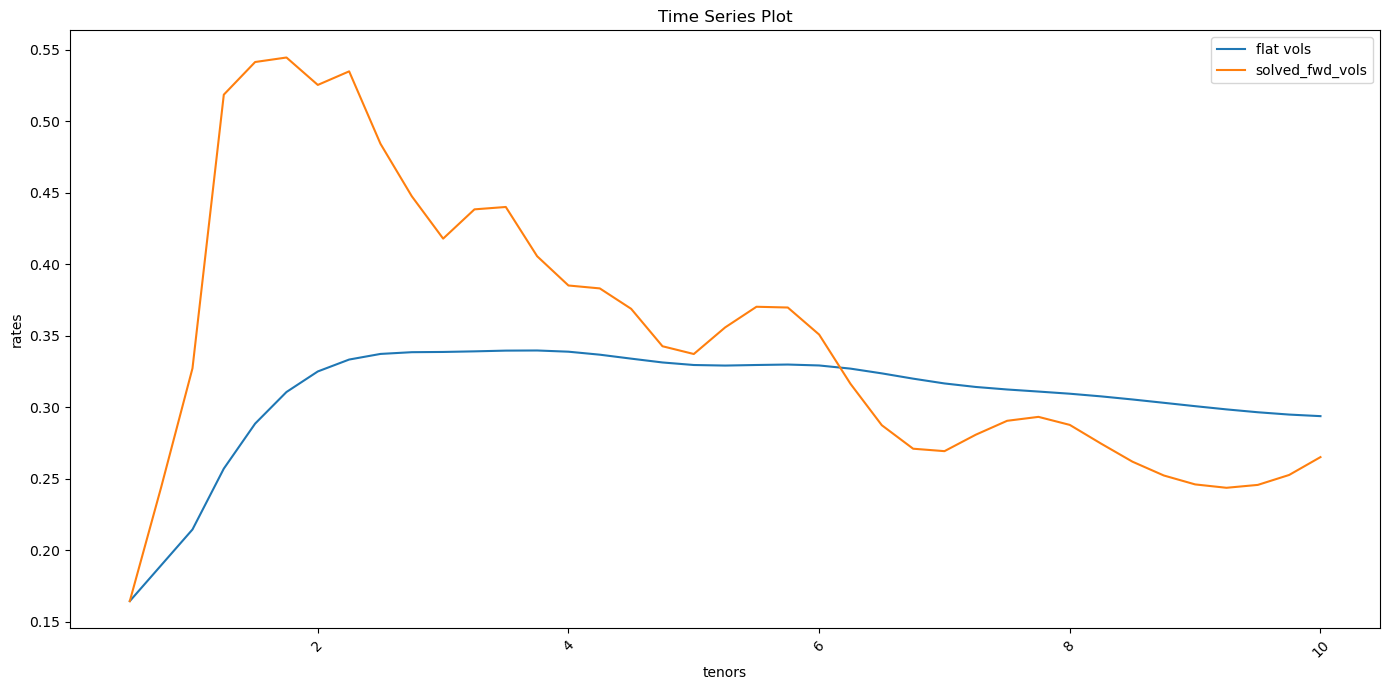

In [7]:
plot_time_series(caplet_prices[['flat vols', 'solved_fwd_vols']], y_label= 'rates', x_label= 'tenors' ,rates = 'trye')

## 1.3 Calibrate a BDT model 

Use data from the file `data/cap_curves_2024-02-16.xlsx` to calibrate the BDT model.
* Use the forward volatilities calculated in 1.2 to calibrate $\sigma$ at each step. 
* You do not have a forward volatility at $\tau=.25$ given there is no caplet there. For purposes of the BDT model, assume $\sigma_{.25}$ is equal to the forward volatility at the first estimated period, $t=0.50$. That is, use the first estimated forward vol (corresponding to $\tau=.50$ for both $t=.25$ and $t=.50$ in the BDT tree.    

Given these volatility parameters, calibrate the series of $\theta$ to fit the zero-coupon bond prices given by `discounts` (multiplied by 100).

**Display**
* the series of $\theta$ parameters.
* the tree of rates from $0\le t \le 10$.

In [8]:
quotes = caplet_prices['discounts']*100
sigmas = caplet_prices['solved_fwd_vols']
sigmas.iloc[0] = sigmas.iloc[1]

theta, ratetree = estimate_theta(sigmas,quotes)
format_bintree(theta.to_frame().T, style='{:.2%}')

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
theta,,-11.18%,-29.62%,-44.17%,-96.03%,-64.37%,-54.44%,-38.46%,-49.59%,-9.02%,0.17%,11.93%,-12.15%,-0.83%,27.02%,21.08%,5.65%,19.09%,40.00%,35.05%,20.19%,15.02%,15.61%,20.20%,27.72%,32.20%,33.55%,31.84%,27.61%,24.58%,23.21%,23.58%,25.41%,26.92%,27.77%,27.95%,27.37%,25.94%,23.58%,20.15%


In [9]:
ratetree

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,
0,0.052869,0.055819,0.058562,0.061761,0.062957,0.070260,0.080507,0.095094,0.109762,0.136710,...,15.923520,19.503005,23.840318,29.068619,35.348338,42.869660,51.854548,62.562552,75.297506,90.414779
1,NaN,0.047352,0.049679,0.052393,0.053408,0.059603,0.068296,0.080670,0.093113,0.115974,...,13.508236,16.544784,20.224212,24.659483,29.986692,36.367178,43.989235,53.073047,63.876359,76.700640
2,NaN,NaN,0.038922,0.041048,0.041843,0.046697,0.053507,0.063202,0.072951,0.090862,...,10.583233,12.962263,15.844967,19.319848,23.493530,28.492419,34.464036,41.580887,50.044907,60.092285
3,NaN,NaN,NaN,0.029593,0.030166,0.033665,0.038575,0.045564,0.052592,0.065505,...,7.629791,9.344910,11.423144,13.928296,16.937238,20.541097,24.846227,29.976992,36.078975,43.322451
4,NaN,NaN,NaN,NaN,0.017961,0.020044,0.022967,0.027129,0.031313,0.039001,...,4.542721,5.563890,6.801255,8.292804,10.084305,12.230016,14.793258,17.848078,21.481153,25.793864
5,NaN,NaN,NaN,NaN,NaN,0.011665,0.013366,0.015788,0.018223,0.022697,...,2.643660,3.237935,3.958026,4.826041,5.868615,7.117322,8.609015,10.386783,12.501070,15.010875
6,NaN,NaN,NaN,NaN,NaN,NaN,0.007754,0.009159,0.010572,0.013167,...,1.533661,1.878417,2.296162,2.799722,3.404548,4.128958,4.994331,6.025664,7.252221,8.708229
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005416,0.006252,0.007786,...,0.906936,1.110808,1.357843,1.655625,2.013291,2.441673,2.953414,3.563297,4.288625,5.149641
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003662,0.004561,...,0.531257,0.650679,0.795385,0.969817,1.179327,1.430261,1.730024,2.087275,2.512152,3.016509


***

# 2. Pricing a Callable Bond with BDT

## Freddie Mac

The U.S. has many forms of *agency* debt in addition to *Treasury* debt. The largest of these *agency* issuers are the housing entities commonly referred to as Freddie Mac and Fannie Mae. While technically distinct from the U.S. Treasury, they are widely seen as having the full credit and backing of the Treasury--particularly after the bailouts of 2008.

Thus, we will examine this agency debt as (credit) risk-free, just like Treasury debt.

Consider the Freddie Mac bond with Bloomberg ID `COZD1131782`, CUSIP `3134H1TN3`.
* Issued 2024-02-16
* Matures 2034-02-21
* Semiannual coupons
* Coupon rate 6.00%

Note that these bonds are not a niche market. Just this particular bond was issued with \$15 billion face value.

In [13]:
F = 100
T=10
compound = 4
cpn = .06
cpn_freq = 2

STRIKE = 100
CLEANCALL = True

dt = 1/compound
tsteps = int(T/dt)

## 2.1 Price the Freddie Mac Bond


Assume today is `2024-02-16`.
* The market price on this day is `$99.953`.
* Approximate the TTM (time-to-maturity) to be exactly 10 years.

Price this bond using the model calibrated from  data.
* Price it with the BDT model calibrated in the previous problem.
* Note that the coupons are paid semiannually whereas the tree steps are quarterly.

Report the tree of bond prices, emphasizing the current modeled price.

How does our modeled price compare to the market price?

In [14]:
wrapper_bond = lambda r: payoff_bond(r, dt, facevalue=F * (1+cpn/cpn_freq))
payoff_call = lambda p: np.maximum(p-STRIKE,0)

cftree = construct_bond_cftree(T, compound, cpn)
bondtree = bintree_pricing(payoff=wrapper_bond, ratetree=ratetree.iloc[:tsteps,:tsteps], cftree=cftree)
format_bintree(bondtree)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,116.65,111.87,103.58,97.71,88.36,81.46,71.30,63.99,53.79,46.77,37.32,31.51,23.63,19.53,13.49,11.29,7.13,6.39,3.51,3.71,1.71,2.29,0.79,1.40,0.29,0.78,0.08,0.36,0.01,0.12,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,,124.53,117.30,112.50,104.11,98.05,88.51,81.51,71.27,63.80,53.47,46.39,36.90,30.94,22.89,18.74,12.75,10.46,6.29,5.57,2.89,3.09,1.26,1.78,0.49,1.00,0.15,0.50,0.03,0.19,0.00,0.05,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
2,,,128.72,125.04,117.84,112.97,104.55,98.55,89.08,82.10,71.88,64.50,54.25,47.09,37.42,31.39,23.33,18.95,12.75,10.34,6.21,5.39,2.71,2.79,1.05,1.49,0.35,0.78,0.09,0.35,0.01,0.12,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00
3,,,,134.90,128.83,125.19,118.05,113.36,105.16,99.34,90.08,83.40,73.49,66.25,56.01,48.96,39.41,33.21,24.87,20.32,14.04,11.37,6.98,5.85,3.00,2.89,1.12,1.44,0.36,0.70,0.09,0.30,0.01,0.09,0.00,0.02,0.00,0.00,0.00,0.00
4,,,,,136.98,134.41,128.44,125.03,118.17,113.76,105.88,100.50,91.71,85.42,75.78,68.95,59.12,52.22,42.63,36.49,28.21,23.48,16.81,13.71,8.85,7.32,4.09,3.71,1.66,1.85,0.58,0.91,0.16,0.41,0.03,0.15,0.00,0.04,0.01,0.16
5,,,,,,140.79,135.73,133.34,127.60,124.43,117.86,113.85,106.42,101.47,93.07,87.30,78.25,71.83,62.30,55.80,46.63,40.68,32.33,27.40,20.42,16.95,11.65,9.70,5.98,5.21,2.74,2.69,1.12,1.37,0.41,0.67,0.17,0.36,0.31,2.42
6,,,,,,,140.67,139.03,134.13,131.93,126.42,123.56,117.34,113.70,106.64,102.18,94.36,89.09,80.49,74.67,65.81,59.83,51.00,45.28,37.03,32.13,25.03,21.35,15.69,13.33,9.11,7.93,4.99,4.65,2.72,2.88,1.81,2.49,3.27,11.68
7,,,,,,,,142.86,138.56,137.05,132.31,130.32,125.06,122.48,116.56,113.30,106.71,102.71,95.35,90.67,82.78,77.62,69.33,63.89,55.56,50.29,42.41,37.77,30.79,27.12,21.33,18.82,14.38,13.06,10.00,9.84,8.39,10.13,13.16,28.43
8,,,,,,,,,141.55,140.51,136.32,134.95,130.38,128.58,123.54,121.23,115.66,112.76,106.56,103.06,96.31,92.25,84.97,80.44,72.81,68.07,60.43,55.82,48.54,44.44,37.91,34.69,29.31,27.32,23.51,23.24,21.85,24.97,30.20,48.45


In [20]:
accint = construct_accint(bondtree.columns.values, compound, cpn)
cleantree = np.maximum(bondtree.subtract(accint,axis=1),0)



In [28]:
display(cleantree.iloc[0,0])
display(99.953)



116.64561764846187

99.953

Without looking at the callable structure of the bond, it looks like the bond is overpriced by the model. The actual price is significantly lower.

## 2.2 Callable Bond

One important difference between Treasury debt and this bond is that this bond is **callable**
* Note that the holder of the bond is short this call option; (the issuer has the optionality.) 

#### Style
* (approximately) American style
* called only on quarterly dates, not any date
* since our tree is quarterly, this means callable on any date on our tree.

#### Strike
* Strike is 100.
* The strike is based on the **clean** price of the bond, meaning the price which does not account for accrued interest.
    * In pricing the bond in the previous problem, you should have considered the accrued coupons, or dirty prices.
    * But in analyzing the option, you must consider its moneyness and payoff based on the clean price.

### Pricing
Use the BDT model to price this implicit American call option and the resulting callable bond.
* Note that the price of the callable bond is your answer to the previous question minus this American option.
* How close is the modeled price to the market quoted price now that you are accounting for the short embedded option? 

Does the price of the callable bond ever get above \$100?

In [29]:
calltree = bintree_pricing(payoff=payoff_call, ratetree=ratetree.iloc[:tsteps,:tsteps], undertree= cleantree, style='american')
cleantree-calltree

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,
0,97.574452,95.306729,92.052890,87.708198,82.297672,75.808855,68.573050,60.772052,52.757106,44.683820,...,0.000661,0.000000,0.000011,0.000000,2.935593e-08,0.000000,6.644242e-12,0.000000,1.669862e-15,0.000000
1,NaN,99.438646,98.281332,96.112817,92.894883,88.397595,82.784514,76.162325,68.783314,60.765833,...,0.002829,0.000000,0.000096,0.000000,7.648433e-07,0.000000,8.115485e-10,0.000000,1.814937e-12,0.000000
2,NaN,NaN,100.000000,99.906350,98.904679,96.889459,93.709818,89.257894,83.705642,77.040663,...,0.014768,0.000000,0.001111,0.000000,2.825938e-05,0.000000,1.596422e-07,0.000000,3.811429e-09,0.000000
3,NaN,NaN,NaN,100.000000,100.000000,100.000000,99.379800,97.685671,94.700966,90.451824,...,0.089391,0.000000,0.014319,0.000000,1.178623e-03,0.000000,3.822450e-05,0.000000,9.987193e-06,0.000000
4,NaN,NaN,NaN,NaN,100.000000,100.000000,100.000000,100.000000,99.942962,98.456830,...,0.578070,0.000000,0.161690,0.000000,3.286682e-02,0.000000,4.871653e-03,0.000000,5.999295e-03,0.000000
5,NaN,NaN,NaN,NaN,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,...,2.742844,1.193725,1.117665,0.000000,4.101249e-01,0.000000,1.652218e-01,0.000000,3.095263e-01,0.915751
6,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,100.000000,100.000000,100.000000,...,9.114899,6.429660,4.986579,3.147315,2.716420e+00,1.384475,1.809182e+00,0.986222,3.271582e+00,10.177590
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,100.000000,100.000000,...,21.325041,17.318692,14.378198,11.559290,9.999363e+00,8.340910,8.386257e+00,8.625218,1.315681e+01,26.926413
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,100.000000,...,37.910675,33.185669,29.306642,25.820160,2.351061e+01,21.741155,2.185194e+01,23.471058,3.019629e+01,46.953357


#### Factoring in the optionality of the call with respect to the issuer however, and it looks like theres a significant decrease in value. from 116 to 97 something. Looks like now my earlier assessment was wrong, and the actual price via the model appears to be undervaluing the bond vs the market. 

- The price never goes above 100. I mean, ofc not, otherwise the issuer will simply call the bond at par.

- Could be that the particular way the model is set up, there might be some market directional movement that we haven't taken into account of in this model, which might explain this discrepancy

## 2.3 Exercising the Option

Show a heatmap of the nodes in which the American bond is exercised.

Is it exercised every time it is in-the-money?

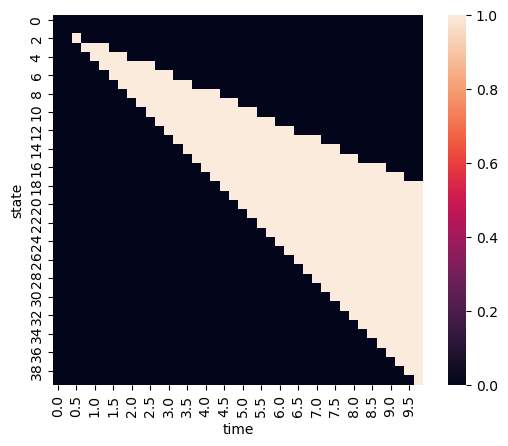

In [31]:

sns.heatmap(exercise_decisions(payoff_call,cleantree,calltree),square=True);



#### While the model suggests that everytime it is advantageous to exercise, the issuer will exercise, this could be a very simplistic way of viewing this. This is because real life financing can be complicated. For example it is possible that while it is advantageous to exercise, the issuer was unable to secure the funds to 'finance' the buyback. The way companies typically finance is by rolling over the debt, that is by issuing new bonds at market rates to finance the call option exercise. There are circumstances where this may not be economically feasible, and so the exercise may not occur. 

***

# 3. Option Adjusted Spread

*This section is optional. No need to submit it, but we will likely discuss it in class.*

## 3.1 Calculate the OAS

The **option adjusted spread** is the spread one would need to add to the spot curve, (the discounts), to get the modeled price to match the market price of the derivative. That is, how many bps would you need to add or subtract to all the spot rates in order to perfectly price this callable bond? 

* Ignore the effect of the parallel shift in rates on the forward vols. (No need to recalculate section 1.) 

* Use the parallel shifts to recalibrate the $\theta$ parameters in the BDT tree. 

Report the OAS needed to add (or subtract) in a parallel shift in spot to correctly model the callable bond.

#### Note:
This **OAS** is a common way to quote whether a derivative seems to be undervalued (positive OAS) or overvalued (negative OAS.) Of course, the OAS is dependent on our modeling choices, so it could also indicate the model is bad.

## 3.2 Convexity

Continue with parallel shifts of the (present, market quoted) yield curve. 
* Plot the relationship between the value of the callable bond as the spot curve shifts higher and lower.
* Do you see convexity in this relationship?

***